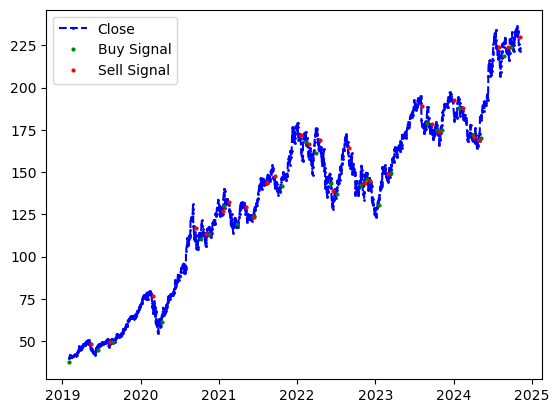

In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

aapl_price_history=yf.Ticker('AAPL').history(start='2019-01-01')#,end='2021-01-01')
aapl_price_history.dropna(inplace=True)

windows=[13,21]
# when the short term moving average is above the long term moving average, the stock is considered bullish

for window in windows:
    aapl_price_history['SMA'+str(window)]=aapl_price_history['Close'].rolling(window=window).mean()

# Create crossover signals
aapl_price_history['SMA_cross'] = np.where(
    aapl_price_history['SMA13'] > aapl_price_history['SMA21'], 1, -1)
# Find where the signal changes (crossover points)
aapl_price_history['crossover'] = aapl_price_history['SMA_cross'].diff()

# Get dates where crossovers occur
crossover_dates = aapl_price_history[aapl_price_history['crossover'] != 0]
first_buy_date = crossover_dates[crossover_dates['crossover'] == 2].index[0]
last_sell_date = crossover_dates[crossover_dates['crossover'] == -2].index[-1]

crossover_dates = crossover_dates.loc[first_buy_date:last_sell_date]
aapl_price_history = aapl_price_history.loc[first_buy_date:last_sell_date]
plt.plot(aapl_price_history['Close'],label='Close',linestyle='--',marker='o',markersize=1,color='blue')

plt.plot(crossover_dates[crossover_dates['crossover']==2].index, crossover_dates[crossover_dates['crossover']==2]['SMA13'], 'go', label='Buy Signal', markersize=2)
plt.plot(crossover_dates[crossover_dates['crossover']==-2].index, crossover_dates[crossover_dates['crossover']==-2]['SMA13'], 'ro', label='Sell Signal', markersize=2)
plt.legend()
#plt.xlim('2020-01-01','2021-01-01')
plt.show()

In [14]:
# Create a copy of the dataframe to avoid the SettingWithCopyWarning
crossover_dates = crossover_dates.copy()
crossover_dates.dropna(inplace=True)
crossover_dates['return'] = np.where(crossover_dates['crossover']==2, 0, crossover_dates['Close'].pct_change())
crossover_dates['value'] = (1+crossover_dates['return']).cumprod()

returns=crossover_dates['return'].to_numpy(dtype=float)
returns=returns[returns!=0]
total_return = np.prod(1+returns)-1
print(f'Stock return without trading: {aapl_price_history['Close'].iloc[-1]*100/aapl_price_history['Close'].iloc[0]:,.2f}%')
print(f'Total return with trading: {total_return*100:,.2f}%')
print('Number of trades:',len(crossover_dates))
print('Hit rate:',len(returns[returns>0])/len(returns))
print(f'Total time: {crossover_dates.index[-1]-crossover_dates.index[0]}')


Stock return without trading: 561.62%
Total return with trading: 244.53%
Number of trades: 58
Hit rate: 0.4482758620689655
Total time: 2105 days 00:00:00


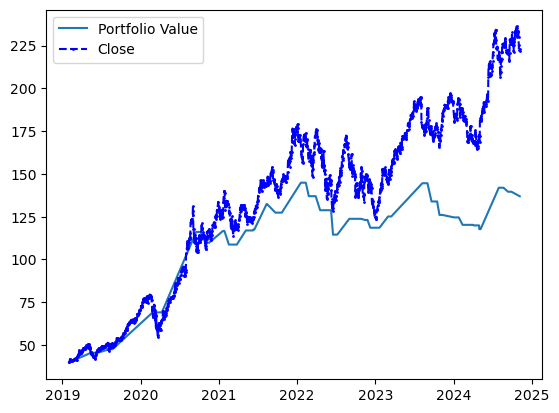

In [15]:
plt.plot(crossover_dates.index, crossover_dates['value']*crossover_dates['Close'].iloc[0], label='Portfolio Value')
plt.plot(aapl_price_history['Close'],label='Close',linestyle='--',marker='o',markersize=1,color='blue')
plt.legend()
plt.show()